# Hands on: Validação de Modelos

Uma empresa do ramo alimentício tem mais de 20 mil colaboradores em todo o Brasil. Com o passar dos anos a empresa percebeu um aumento no custo do plano de saúde com seus colaboradores. Como forma de entender esse comportamento, a gerência de Benefícios e Bem Estar da Diretoria de Pessoas conduziu uma pesquisa interna com um grupo de 1.338 colaboradores sorteados aleatoriamente ao longo de um ano.

A gerência acredita que fatores como fumo e obesidade podem estar relacionados com o maior uso do plano de saúde, o que acaba elevando os custos. Portanto, os colaboradores da pesquisa responderam características pessoais como o Índice de Massa Corpórea (IMC), Qte de Filhos e se fazem uso de cigarros. Segue abaixo o dicionário dos dados:

#### Dicionário de dados

| Variável | Descrição |
| ------ | ------ |
| DtRef | Data de Referência quando a pesquisa com o colaborador foi realizada |
| Idade | Idade do colaborador |
| Sexo | Sexo do colaborador |
| IMC | Índice de Massa Corporal do colaborador |
| Qte_filhos | Qte de filhos que o colaborador tem |
| Fumante | Flag se o colaborador é fumante ou não fumante |
| Regiao | Região do Brasil onde o colaborador mora |
| Custo_Saude | Custo de Plano de Saúde que esse colaborador trouxe para a empresa 3 meses depois da Data de Referência|

Com base nessas informações, pede-se:

- **Desenvolver um modelo que estime os custos de saúde dos próximos 3 meses dos colaboradores**
- **Validar o modelo com técnicas Out of Sample, Out of Time e Validação Cruzada**
- **Qual sua conclusão a respeito do melhor tipo de validação para o problema? Qual sua estimativa para a medida de performance esperada do modelo quando for usado para prever o custo do plano de saúde?**







#### Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aed

#modelo a ser treinado
from sklearn import linear_model

#métrica de performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#particionamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

#### Importação da base de dados

In [2]:
df = pd.read_excel("/home/lucasmateus/dbt-projects/projetos_lucas/curso_preditiva/diagnosticos_modelo/base_custos_saude.xlsx")
df

,DtRef,Idade,Sexo,IMC,Qte_Filhos,Fumante,Regiao,Custo_Saude
0,202101,25,Masculino,26.220,0,Não,Nordeste,272.132080
1,202101,23,Masculino,17.385,1,Não,Norte,277.519215
2,202101,41,Masculino,21.780,1,Não,Sudeste,627.247720
3,202101,38,Masculino,37.050,1,Não,Nordeste,607.967150
4,202101,60,Feminino,24.530,0,Não,Sudeste,1262.989670
...,...,...,...,...,...,...,...,...
1333,202112,24,Masculino,31.065,0,Sim,Nordeste,3425.405335
1334,202112,43,Masculino,25.520,5,Não,Sudeste,1447.833015
1335,202112,19,Masculino,34.900,0,Sim,Centro,3482.865400
1336,202112,45,Masculino,30.360,0,Sim,Sudeste,6259.287309


#### 1) Análise Exploratória inicial

In [3]:
perfil_pp, perfil_sv = aed.gera_relatorios_aed(df=df,
                                               target_feat='Custo_Saude')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report base_aed_sv.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
df.isnull().sum()

DtRef          0
Idade          0
Sexo           0
IMC            0
Qte_Filhos     0
Fumante        0
Regiao         0
Custo_Saude    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DtRef        1338 non-null   int64  
 1   Idade        1338 non-null   int64  
 2   Sexo         1338 non-null   object 
 3   IMC          1338 non-null   float64
 4   Qte_Filhos   1338 non-null   int64  
 5   Fumante      1338 non-null   object 
 6   Regiao       1338 non-null   object 
 7   Custo_Saude  1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [8]:
df_2 = pd.get_dummies(df, columns=['Sexo', 'Fumante', 'Regiao'])
df_2

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude,Sexo_Feminino,Sexo_Masculino,Fumante_Não,Fumante_Sim,Regiao_Centro,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste
0,202101,25,26.220,0,272.132080,0,1,1,0,0,1,0,0
1,202101,23,17.385,1,277.519215,0,1,1,0,0,0,1,0
2,202101,41,21.780,1,627.247720,0,1,1,0,0,0,0,1
3,202101,38,37.050,1,607.967150,0,1,1,0,0,1,0,0
4,202101,60,24.530,0,1262.989670,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,202112,24,31.065,0,3425.405335,0,1,0,1,0,1,0,0
1334,202112,43,25.520,5,1447.833015,0,1,1,0,0,0,0,1
1335,202112,19,34.900,0,3482.865400,0,1,0,1,1,0,0,0
1336,202112,45,30.360,0,6259.287309,0,1,0,1,0,0,0,1


In [9]:
df_2['DtRef'].unique()

array([202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108,
       202109, 202110, 202111, 202112])

#### 2) Análise de Correlação

In [10]:
# definindo a variável dependente
y = df_2['Custo_Saude']

# definindo as variáveis independentes
x = df_2.drop(['Custo_Saude', 'DtRef'], axis=1)

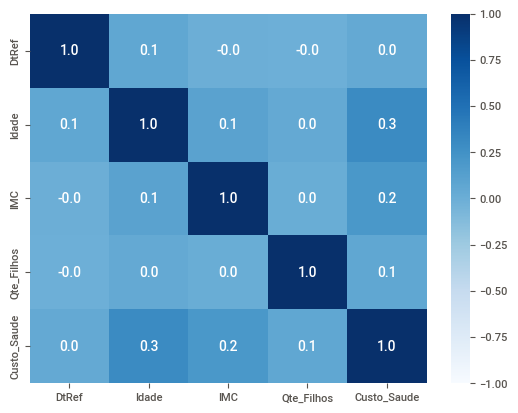

In [11]:
# Create the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix,
            cmap='Blues',
            vmin=-1, vmax=1,
            annot=True,
            fmt=".1f")  # Add annotations for coefficients
plt.show()

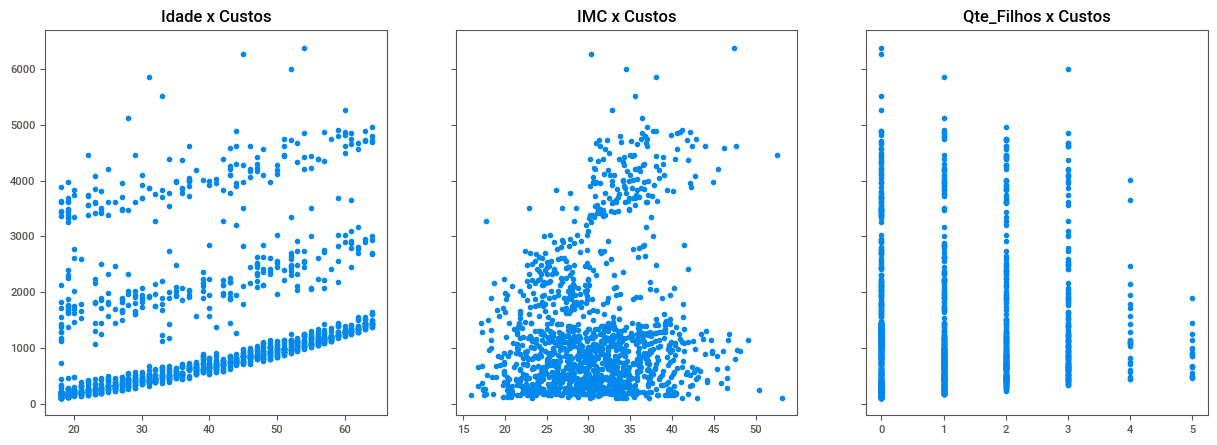

In [33]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax1.scatter(df['Idade'],df['Custo_Saude'])
ax1.set_title('Idade x Custos')

ax2.scatter(df['IMC'],df['Custo_Saude'])
ax2.set_title('IMC x Custos')

ax3.scatter(df['Qte_Filhos'],df['Custo_Saude'])
ax3.set_title('Qte_Filhos x Custos')

plt.show()


<Axes: xlabel='Idade', ylabel='Custo_Saude'>

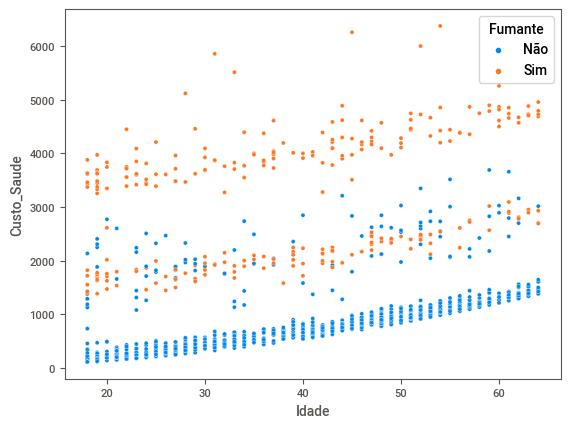

In [37]:
# Investigando relação Custo x Idade por Fumante
sns.scatterplot(data=df, x='Idade', y='Custo_Saude', hue='Fumante')

#### 3) Desenvolvimento do modelo

In [13]:
model = linear_model.LinearRegression()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [15]:
model.fit(X_train, y_train)

LinearRegression()

##### 3.1) Validação Out of Sample

In [16]:
y_pred = model.predict(X_test)

In [17]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 411276.9681235362
R-squared: 0.7366066232383949
Mean Absolute Error (MAE): 452.9130558894447


##### 3.2) Validação Cruzada K-Fold

In [18]:
particoes = KFold(n_splits = 5, shuffle = True, random_state = 42) 

In [19]:
mse_scores = []
r2_scores = []
mae_scores = []

for train_index, test_index in particoes.split(x):
    
    # Separa a base    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treina o modelo
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)

    # Validation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Append scores to lists
    mse_scores.append(mse)
    r2_scores.append(r2)
    mae_scores.append(mae)
    
resultado = pd.DataFrame({"Mean Square Error Scores":mse_scores, "R2 Scores":r2_scores, "Mean Absolute Error Scores":mae_scores})
resultado

,Mean Square Error Scores,R2 Scores,Mean Absolute Error Scores
0,433345.865337,0.740228,460.759136
1,351195.350039,0.754157,422.905532
2,361008.173909,0.715936,404.034442
3,333360.464223,0.775681,390.443029
4,387193.318830,0.734160,430.987845


In [20]:
resultado.describe().loc[['mean','std']]

,Mean Square Error Scores,R2 Scores,Mean Absolute Error Scores
mean,373220.634468,0.744032,421.825997
std,38837.384742,0.022392,26.936612


In [21]:
# Calculate and print average metrics
print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average R-squared:", np.mean(r2_scores))
print("Average Mean Absolute Error:", np.mean(mae_scores))

Average Mean Squared Error: 373220.6344676216
Average R-squared: 0.7440322613658457
Average Mean Absolute Error: 421.82599684150665


##### 3.3) Validação Out of Time

In [22]:
# Transformando a coluna int64 em data
df_2['DtRef'] = pd.to_datetime(df_2['DtRef'].astype(str), format='%Y%m')

In [23]:
# Segmentando em mês e ano (ano seria desnecessário para essa base)
df_2['Year'] = df_2['DtRef'].dt.year
df_2['Month'] = df_2['DtRef'].dt.month

In [24]:
df_2

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude,Sexo_Feminino,Sexo_Masculino,Fumante_Não,Fumante_Sim,Regiao_Centro,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste,Year,Month
0,2021-01-01,25,26.220,0,272.132080,0,1,1,0,0,1,0,0,2021,1
1,2021-01-01,23,17.385,1,277.519215,0,1,1,0,0,0,1,0,2021,1
2,2021-01-01,41,21.780,1,627.247720,0,1,1,0,0,0,0,1,2021,1
3,2021-01-01,38,37.050,1,607.967150,0,1,1,0,0,1,0,0,2021,1
4,2021-01-01,60,24.530,0,1262.989670,1,0,1,0,0,0,0,1,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,2021-12-01,24,31.065,0,3425.405335,0,1,0,1,0,1,0,0,2021,12
1334,2021-12-01,43,25.520,5,1447.833015,0,1,1,0,0,0,0,1,2021,12
1335,2021-12-01,19,34.900,0,3482.865400,0,1,0,1,1,0,0,0,2021,12
1336,2021-12-01,45,30.360,0,6259.287309,0,1,0,1,0,0,0,1,2021,12


In [25]:
# Define training and validation month based on your needs
train_month = range(1, 9)  # Example: Train on data from Jan-June 2021
val_month = range(9, 13)  # Example: Validate on data from July-Dec 2021

train_data = df_2[(df_2['Year'] == 2021) & (df_2['Month'].isin(train_month ))]
val_data = df_2[(df_2['Year'] == 2021) & (df_2['Month'].isin(val_month))]

In [26]:
x_train_otv = train_data.drop(['DtRef', 'Year', 'Month', 'Custo_Saude'], axis=1)
y_train_otv = train_data['Custo_Saude']

x_test_otv = val_data.drop(['DtRef', 'Year', 'Month', 'Custo_Saude'], axis=1)
y_test_otv = val_data['Custo_Saude']

In [27]:
model.fit(x_train_otv, y_train_otv)

LinearRegression()

In [28]:
y_pred_otv = model.predict(x_test_otv)

In [29]:
# Calculate evaluation metrics
mse_otv = mean_squared_error(y_test_otv, y_pred_otv)
r2_otv = r2_score(y_test_otv, y_pred_otv)
mae_otv = mean_absolute_error(y_test_otv, y_pred_otv)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse_otv)
print("R-squared:", r2_otv)
print("Mean Absolute Error (MAE):", mae_otv)

Mean Squared Error (MSE): 357116.6649460082
R-squared: 0.7802523600425888
Mean Absolute Error (MAE): 410.3137542777473


##### 3.3) Validação Out of Time - Acompanhamento o R2 ao longo do tempo

In [42]:
df_2['Custo_Saude_Estimado'] = model.predict(df_2.drop(['Custo_Saude','DtRef','Month','Year'],axis = 1))

In [46]:
df_2['DtRef'] = df_2['DtRef'].astype(str)

In [48]:
df_2['DtRef'].unique()

array(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
      dtype=object)

In [50]:
r2_por_ano_mes = {}

for anomes in df_2['DtRef'].unique():
    df_anomes = df_2[df_2['DtRef'] == anomes]
    r2 = r2_score(df_anomes['Custo_Saude'],df_anomes['Custo_Saude_Estimado'])
    r2_por_ano_mes.update( {anomes : r2} )
    
df_r2_por_ano_mes = pd.DataFrame(r2_por_ano_mes,[0]).T.rename(columns={0: 'R2'})

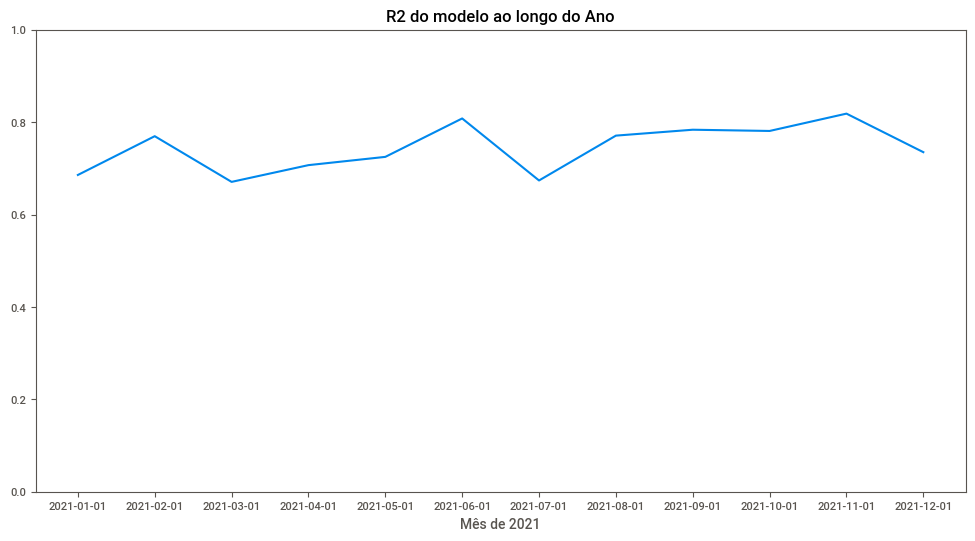

In [51]:
plt.figure(figsize=(12,6))
plt.plot(df_r2_por_ano_mes['R2'])
plt.ylim(bottom=0,top=1);

plt.title("R2 do modelo ao longo do Ano");
plt.xlabel("Mês de 2021");

In [55]:
df_r2_por_ano_mes.T

,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01
R2,0.68562,0.76954,0.670654,0.706893,0.724774,0.807934,0.67371,0.770771,0.78354,0.780874,0.818386,0.734972
